CSE 546 - Reinforcement learning
# Assignment 1 - Defining & Solving RL Environments

Installing Gym library

In [ ]:
!pip install gym

Importing required libraries

In [ ]:
import gym
import time
import random
import numpy as np
import matplotlib.pyplot as plt

from gym import spaces
from google.colab import widgets

## Part 1 - Defining RL Environment

Initializing the positions of the agent, goal, and rewards.

In [ ]:
init_agent_pos= [0, 0]
init_diamond_pos= [0, 2]
init_monster_pos= [1, 1]
init_goal_pos= [2, 2]

Pre-defining the minimum number of states and actions that will be used in the environment

In [ ]:
MIN_STATE= 9
MIN_ACTION= 4
MAX_TIMESTEPS= 10

Therefore,
1. State set: {(0, 0), (0, 1), (0, 2), (1, 1), (1, 2), (1, 3), (2, 1), (2, 2), (2, 3)}
2. Action set: {Up, Down, Left, Right}
3. Reward set: {-5, 1, 5, 10}

### Deterministic Learning Environment

In [ ]:
class DeterministicEnvironment(gym.Env):
  metadata= {'render.modes': []}

  def __init__(self):
    self.observation_space= spaces.Discrete(MIN_STATE)
    self.action_space= spaces.Discrete(MIN_ACTION)
    self.max_timesteps= MAX_TIMESTEPS

  def reset(self):
    self.timestep= 0

    self.agent_pos= [0, 0]
    self.diamond_pos= [0, 2]
    self.monster_pos= [2, 0]
    self.goal_pos= [2, 2]

    self.state= np.zeros((3, 3))
    self.state[tuple(self.agent_pos)]= 1
    self.state[tuple(self.diamond_pos)]= 5
    self.state[tuple(self.monster_pos)]= -5
    self.state[tuple(self.goal_pos)]= 10

    observation= self.agent_pos

    return observation

  def step(self, action):
    if action == 0: # Go down one step
      self.agent_pos[0] += 1
    if action == 1: # Go up one step
      self.agent_pos[0] -= 1
    if action == 2: # Go right one step
      self.agent_pos[1] += 1
    if action == 3: # Go left one step
      self.agent_pos[1] -= 1

    self.agent_pos= np.clip(self.agent_pos, 0, 2)
    self.state= np.zeros((3, 3))
    self.state[tuple(self.agent_pos)]= 1
    self.state[tuple(self.diamond_pos)]= 5
    self.state[tuple(self.monster_pos)]= -5
    self.state[tuple(self.goal_pos)]= 10

    observation= self.agent_pos

    reward= 0
    if(self.agent_pos == self.diamond_pos).all():
      reward += 5
    if(self.agent_pos == self.monster_pos).all():
      reward -= 5
    if(self.agent_pos == self.goal_pos).all():
      reward += 10
    
    self.timestep += 1

    done= True if ((self.timestep >= self.max_timesteps) or (self.agent_pos == self.goal_pos).all()) else False
    info= {}

    return observation, reward, done, info
  
  def render(self):
    plt.imshow(self.state)

The following shows the default environment setup

Legend:
* Turquoise - Agent's initial position (0, 0)
* Green - Diamond position (0, 2)
* Yellow - Goal position (2, 2)
* Blue - Empty states 

[0, 0]


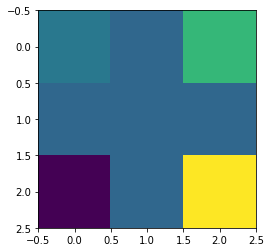

In [ ]:
det_env= DeterministicEnvironment()
observation= det_env.reset()
print(observation)
det_env.render()

**Test 1:** Simulating one action

----- For action 0 -----
Current state: [1 0]
Reward for action taken: 0
Any info? - {}
Are you done? - False


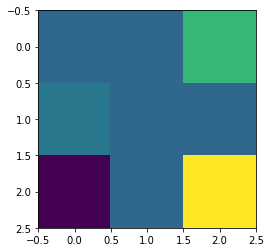

In [ ]:
take_action= 0
observation, reward, done, info= det_env.step(action= take_action)
det_env.render()

print('----- For action {} -----'.format(take_action))
print('Current state: {}'.format(observation))
print('Reward for action taken: {}'.format(reward))
print('Any info? - {}'.format(info))
print('Are you done? - {}'.format(done))

**Test 2:** Simulating a sequence of actions

----- For action 2 -----
Current state: [0 1]
Reward for action taken: 0
Any info? - {}
Are you done? - False
Total reward obtained so far - 0
----- For action 2 -----
Current state: [0 2]
Reward for action taken: 5
Any info? - {}
Are you done? - False
Total reward obtained so far - 5
----- For action 0 -----
Current state: [1 2]
Reward for action taken: 0
Any info? - {}
Are you done? - False
Total reward obtained so far - 5
----- For action 0 -----
Current state: [2 2]
Reward for action taken: 10
Any info? - {}
Are you done? - True
Total reward obtained so far - 15
This path gives a total reward of 15


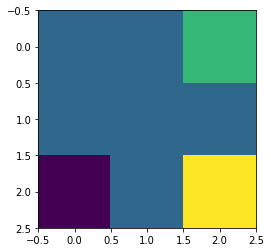

In [ ]:
det_env.reset()
action_list= [2, 2, 0, 0] # Move 2 steps right and then 2 steps down
# action_list= [2, 0, 0, 2]
# action_list= [0, 0, 2, 2]

cumulative_reward= 0
for each_action in action_list:
  observation, reward, done, info= det_env.step(action= each_action)  
  cumulative_reward += reward

  print('----- For action {} -----'.format(each_action))
  print('Current state: {}'.format(observation))
  print('Reward for action taken: {}'.format(reward))
  print('Any info? - {}'.format(info))
  print('Are you done? - {}'.format(done))
  print('Total reward obtained so far - {}'.format(cumulative_reward))

print('This path gives a total reward of {}'.format(cumulative_reward))
det_env.render()

### Stochastic Learning Environment

In [ ]:
class StochasticEnvironment(gym.Env):
  metadata= {'render.modes': []}

  def __init__(self):
    self.observation_space= spaces.Discrete(MIN_STATE)
    self.action_space= spaces.Discrete(MIN_ACTION)
    self.max_timesteps= MAX_TIMESTEPS

  def reset(self):
    self.timestep= 0

    self.agent_pos= [0, 0]
    self.diamond_pos= [0, 2]
    self.monster_pos= [2, 0]
    self.goal_pos= [2, 2]

    self.state= np.zeros((3, 3))
    self.state[tuple(self.agent_pos)]= 1
    self.state[tuple(self.diamond_pos)]= 5
    self.state[tuple(self.monster_pos)]= -5
    self.state[tuple(self.goal_pos)]= 10

    observation= self.agent_pos

    return observation

  def step(self, action):

    # Adds a level of uncertainity to the environment
    action= action if (random.uniform(0, 1) > 0.75) else np.random.choice(self.action_space.n)

    if action == 0: # Go down one step
      self.agent_pos[0] += 1
    elif action == 1: # Go up one step
      self.agent_pos[0] -= 1
    elif action == 2: # Go right one step
      self.agent_pos[1] += 1
    elif action == 3: # Go left one step
      self.agent_pos[1] -= 1
    else:
      raise Exception

    self.agent_pos= np.clip(self.agent_pos, 0, 2)
    self.state= np.zeros((3, 3))
    self.state[tuple(self.agent_pos)]= 1
    self.state[tuple(self.diamond_pos)]= 5
    self.state[tuple(self.monster_pos)]= -5
    self.state[tuple(self.goal_pos)]= 10

    observation= self.agent_pos

    reward= 0
    if(self.agent_pos == self.diamond_pos).all():
      reward += 5
    if(self.agent_pos == self.monster_pos).all():
      reward -= 5
    if(self.agent_pos == self.goal_pos).all():
      reward += 10
    
    self.timestep += 1

    done= True if ((self.timestep >= self.max_timesteps) or (self.agent_pos == self.goal_pos).all()) else False
    info= {}

    return observation, reward, done, info
  
  def render(self):
    plt.imshow(self.state)

The following shows the default environment setup

Legend:
* Turquoise - Agent's initial position (0, 0)
* Green - Diamond position (0, 2)
* Yellow - Goal position (2, 2)
* Blue - Empty states 

[0, 0]


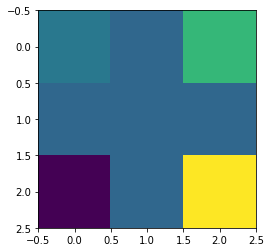

In [ ]:
sto_env= StochasticEnvironment()
observation= sto_env.reset()
print(observation)
sto_env.render()

**Test 1:** Simulating one action

----- For action 0 -----
Current state: [1 0]
Reward for action taken: 0
Any info? - {}
Are you done? - False


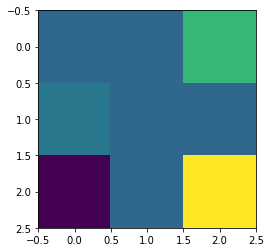

In [ ]:
take_action= 0
observation, reward, done, info= sto_env.step(action= take_action)
sto_env.render()

print('----- For action {} -----'.format(take_action))
print('Current state: {}'.format(observation))
print('Reward for action taken: {}'.format(reward))
print('Any info? - {}'.format(info))
print('Are you done? - {}'.format(done))

**Test 2:** Simulating a sequence of actions

----- For action 2 -----
Current state: [0 1]
Reward for action taken: 0
Any info? - {}
Are you done? - False
Total reward obtained so far - 0
----- For action 2 -----
Current state: [0 2]
Reward for action taken: 5
Any info? - {}
Are you done? - False
Total reward obtained so far - 5
----- For action 0 -----
Current state: [1 2]
Reward for action taken: 0
Any info? - {}
Are you done? - False
Total reward obtained so far - 5
----- For action 0 -----
Current state: [2 2]
Reward for action taken: 10
Any info? - {}
Are you done? - True
Total reward obtained so far - 15
This path gives a total reward of 15


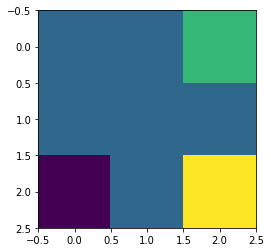

In [ ]:
sto_env.reset()
action_list= [2, 2, 0, 0] # Move 2 steps right and then 2 steps down
# action_list= [2, 0, 0, 2]
# action_list= [0, 0, 2, 2]

cumulative_reward= 0
for each_action in action_list:
  observation, reward, done, info= sto_env.step(action= each_action)  
  cumulative_reward += reward

  print('----- For action {} -----'.format(each_action))
  print('Current state: {}'.format(observation))
  print('Reward for action taken: {}'.format(reward))
  print('Any info? - {}'.format(info))
  print('Are you done? - {}'.format(done))
  print('Total reward obtained so far - {}'.format(cumulative_reward))

print('This path gives a total reward of {}'.format(cumulative_reward))
sto_env.render()

### Random Agent

Inititalizing a random agent

In [ ]:
class RandomAgent:

  def __init__(self, env):
    self.env= env
    self.observation_space= env.observation_space
    self.action_space= env.action_space

  def step(self, observation):
    return np.random.choice(self.action_space.n)

Running the random agent in the *deterministic* environment

""


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[1 0] 0 False {}


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[1 0] 0 False {}


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[1 1] 0 False {}


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[2 1] 0 False {}


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[2 1] 0 False {}


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[2 2] 10 True {}


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

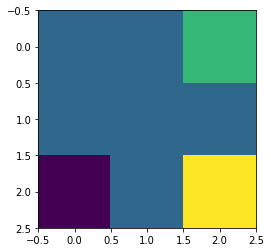

<IPython.core.display.Javascript object>

In [ ]:
det_environment= DeterministicEnvironment()
det_agent= RandomAgent(env= det_environment)
det_observation= det_environment.reset()
det_done= False

det_output_grid= widgets.Grid(1, 1)

# Test render of environment within widget grid
with det_output_grid.output_to(0, 0):
  det_environment.render()

# MDP loop
while not det_done:
  det_action= det_agent.step(det_observation)
  det_observation, det_reward, det_done, det_info= det_environment.step(det_action)
  print(det_observation, det_reward, det_done, det_info)

  with det_output_grid.output_to(0, 0):
    det_output_grid.clear_cell()
    det_environment.render()
    time.sleep(1)

Running the random agent in the *stochastic* environment

""


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[0 1] 0 False {}


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[1 1] 0 False {}


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[1 0] 0 False {}


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[0 0] 0 False {}


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[0 0] 0 False {}


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[0 0] 0 False {}


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[0 1] 0 False {}


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[0 0] 0 False {}


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[0 1] 0 False {}


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[1 1] 0 True {}


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

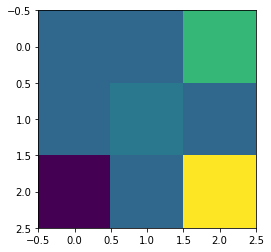

<IPython.core.display.Javascript object>

In [ ]:
sto_environment= StochasticEnvironment()
sto_agent= RandomAgent(env= sto_environment)
sto_observation= sto_environment.reset()
sto_done= False

sto_output_grid= widgets.Grid(1, 1)

# Test render of environment within widget grid
with sto_output_grid.output_to(0, 0):
  sto_environment.render()

# MDP loop
while not sto_done:
  sto_action= sto_agent.step(det_observation)
  sto_observation, sto_reward, sto_done, sto_info= sto_environment.step(sto_action)
  print(sto_observation, sto_reward, sto_done, sto_info)

  with sto_output_grid.output_to(0, 0):
    sto_output_grid.clear_cell()
    sto_environment.render()
    time.sleep(1)